# CICERO SCM notebook example - interactive input

Import some stuff

In [1]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
import logging

try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message=".*Parameter.*")

In [142]:
from openscm_runner.adapters.utils.cicero_utils.cicero_forcing_postprocessing_common import openscm_to_cscm_dict


In [3]:
from ciceroscm.parallel._configdistro import _ConfigDistro
from ciceroscm.parallel.calibrator import Calibrator
from ciceroscm.parallel.distributionrun import DistributionRun


/Users/sanderson/Documents/GitHub/ciceroscm/venv/lib/python3.12/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


Import the model

In [4]:
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [5]:
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Define a function to convert model output to a dataframe

In [6]:
def to_df(cscm):
    out=pd.concat([pd.DataFrame(v) for k, v in cscm.results.items()], axis = 1, keys = list(cscm.results.keys()))
    return out

set up input directories

In [7]:
test_data_dir = os.path.join(os.getcwd(), '../', 'tests', 'test-data')

# Read in datafiles into dataframes

In [8]:
# NBVAL_IGNORE_OUTPUT
#Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_S,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [9]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')
df_nat_ch4.head()


,CH4
year,
1750,269.4273
1751,270.9068
1752,273.0183
1753,272.0470
1754,271.1915


Read forcing

In [10]:
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_ssp2_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
Component,,,,,,,,,,,,,,,,,,,,,
1700,276.746000,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.749995,706.247004,272.243047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.757998,706.375031,272.266047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.757001,706.491002,272.298047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.755000,706.602046,272.331052,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [11]:
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input.head()

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1750,0.002592,0.081127,19.019783,0.054710,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.927690,1.353250,12.520269,0.744520,2.927399
1751,0.002593,0.082619,18.915109,0.055744,1.206598,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828060,343.926367,59.088126,6.860142,1.335274,12.279280,0.737652,2.909437
1752,0.002594,0.084139,18.889712,0.056797,1.200955,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828658,341.809034,58.631997,6.819482,1.326617,12.121816,0.737695,2.912659
1753,0.002594,0.085687,19.121377,0.057870,1.207757,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.812105,343.675456,59.026349,6.881439,1.328560,12.249330,0.743391,2.933215
1754,0.002595,0.087263,19.509061,0.058963,1.233495,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.841598,349.815625,60.269945,7.015189,1.346553,12.593635,0.752796,2.965138


# Set up model run with defined input variables

In [30]:
scendata={
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":True,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
            "udir": test_data_dir,
            "scenname": "ssp245",
        }

In [13]:
    calibdata = pd.DataFrame(
        data={
            "Variable Name": [
                "Heat Content|Ocean",
                "Surface Air Ocean Blended Temperature Change",
            ],
            "Yearstart_norm": [1971, 1961],
            "Yearend_norm": [1971, 1990],
            "Yearstart_change": [2018, 2000],
            "Yearend_change": [2018, 2019],
            "Central Value": [320.69251537323, 0.5372],
            "sigma": [17.020342912051203, 0.039028311931729676],
        })

In [32]:
    testconfig = _ConfigDistro(
        distro_array=[],
        ordering=["aerosol_total", "W", "lambda", "beta_f"],
        setvalues={
            "threstemp": 7.0,
            "lm": 40,
            "ldtime": 12,
            "qbmb": 0,
            "qo3": 0.5,
            "qh2o_ch4": 0.091915,
            "rlamdo": 16,
            "akapa": 0.634,
            "cpi": 0.4,
            "beto": 3.5,
            "mixed": 60,
            "foan":0.61,
        },
        options={"aerosol_total": [-0.36, -0.97, 0.16, -0.08]}
    )

In [15]:
testconfig.ordering

['aerosol_total', 'W', 'lambda', 'beta_f']

In [149]:
vars=list(openscm_to_cscm_dict.keys())
[s for s in vars if 'CO2' in s]

['Effective Radiative Forcing|CO2',
 'Emissions|CO2',
 'Atmospheric Concentrations|CO2']

In [166]:
distrorun1 = DistributionRun(testconfig, numvalues=1000)
output_vars = ["Heat Uptake", "Surface Air Temperature Change", 'Atmospheric Concentrations|CO2']


[-3.          0.55        0.53908356  0.11      ]
[-0.5         2.55        1.34770889  0.465     ]


In [167]:

results1 = distrorun1.run_over_distribution(scendata, output_vars)


Parallel runs:   0%|          | 0.00/4.00 [00:00<?, ?it/s]

Parameter udir is not used. Please check if you have a typo
Parameter scenname is not used. Please check if you have a typo
Parameter udir is not used. Please check if you have a typo
Parameter scenname is not used. Please check if you have a typo
Parameter udir is not used. Please check if you have a typo
Parameter scenname is not used. Please check if you have a typo
Parameter udir is not used. Please check if you have a typo
Parameter scenname is not used. Please check if you have a typo
Parameter foan not in pamset. Using default value 0.61
Parameter foas not in pamset. Using default value 0.81
Parameter ebbeta not in pamset. Using default value 0.0
Parameter fnso not in pamset. Using default value 0.7531
Parameter foan is not used. Please check if you have a typo
Parameter ref_yr not in pamset. Using default value 2010
Parameter mixed_carbon not in pamset. Using default value 75.0
Parameter foan not in pamset. Using default value 0.61
Parameter foas not in pamset. Using default va

In [152]:
df=results1.timeseries()

<Axes: xlabel='time'>

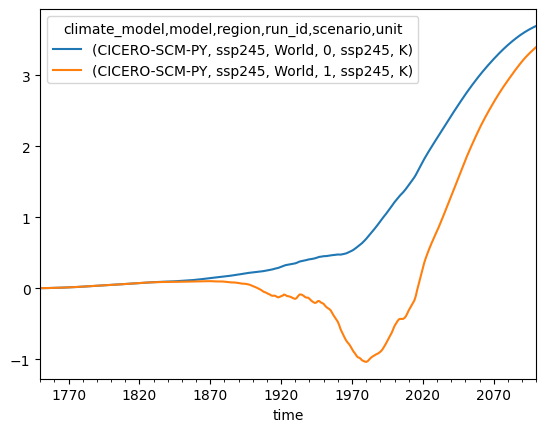

In [153]:
df.xs(output_vars[1], level='variable').T.plot()

In [154]:
df.xs(output_vars[1], level='variable')['2020-01-01'].values

array([1.78341391, 0.28645324])

In [155]:
df['2020-01-01']

climate_model  model   region  run_id  scenario  unit   variable                      
CICERO-SCM-PY  ssp245  World   0       ssp245    W/m^2  Heat Uptake                         1.293987
                                                 K      Surface Air Temperature Change      1.783414
                                                 ppm    Atmospheric Concentrations|CO2    414.389964
                               1       ssp245    W/m^2  Heat Uptake                         1.393976
                                                 K      Surface Air Temperature Change      0.286453
                                                 ppm    Atmospheric Concentrations|CO2    414.389964
Name: 2020-01-01 00:00:00, dtype: float64

In [156]:
df.groupby(['run_id', 'variable'])['2020-01-01'].sum().unstack()

variable,Atmospheric Concentrations|CO2,Heat Uptake,Surface Air Temperature Change
run_id,,,
0,414.389964,1.293987,1.783414
1,414.389964,1.393976,0.286453


In [165]:
dates=['1950-01-01','1970-01-01','1990-01-01','2005-01-01','2018-01-01']
df2=pd.concat([df.groupby(['run_id', 'variable'])[d].sum().unstack() for d in dates],axis=1)   
df2.columns=pd.MultiIndex.from_product([dates,output_vars])
df2

1950-01-01                                 \
       Heat Uptake Surface Air Temperature Change   
run_id                                              
0       312.820976                       0.221042   
1       312.820976                      -0.298921   

                                       1970-01-01  \
       Atmospheric Concentrations|CO2 Heat Uptake   
run_id                                              
0                            0.450117  324.782956   
1                           -0.221436  324.782956   

                                                                      \
       Surface Air Temperature Change Atmospheric Concentrations|CO2   
run_id                                                                 
0                            0.313277                       0.528131   
1                           -0.959111                      -0.857866   

        1990-01-01                                 \
       Heat Uptake Surface Air Temperature Change   
run_id                                              
0       354.072932                       0.772626   
1       354.072932                      -0.196418   

                                       2005-01-01  \
       Atmospheric Concentrations|CO2 Heat Uptake   
run_id                                              
0                            0.942227  378.907008   
1                           -0.896083  378.907008   

                                                                      \
       Surface Air Temperature Change Atmospheric Concentrations|CO2   
run_id                                                                 
0                            0.917169                       1.327834   
1                            0.164299                      -0.434054   

        2018-01-01                                 \
       Heat Uptake Surface Air Temperature Change   
run_id                                              
0       408.631966                       1.242196   
1       408.631966                       1.227481   

                                       
       Atmospheric Concentrations|CO2  
run_id                                 
0                            1.708005  
1                            0.129421